In [8]:
import numpy as np
import scipy.signal
from scipy.optimize import minimize
import pandas as pd
pd.set_option('max_columns', None)
from sklearn import linear_model
import matplotlib.pyplot as plt
from datetime import datetime
plt.rcParams['figure.figsize'] = [15, 7.5]
plt.rcParams.update({'font.size': 16,'legend.fontsize':16})
import seaborn as sns
import sys
import os
import fur.path_assistant as path_assistant
from fur.waveform_reader import read_waveform
from fur.finding_period import get_period
from fur.fluctuations import get_fluctiation_and_noise_var
from fur.one_data_set_analyzer import analyze_one_dataset
from fur.extending_with_acnet_data import get_fluctuations_df_with_acnet_data, get_acnet_df_with_bunch_sizes
shift = path_assistant.PathAssistant('shift_03_16_2020',
    ignore_files=['RefCurve_2020-03-16_0_084020_test.Wfm.bin',
                  'RefCurve_2020-03-16_153_155200.Wfm.bin'])
#shift_03_09_2020.show_waveform_file_names()
waveforms_dir = shift.get_waveforms_dir()
results_dir = shift.get_results_dir()
from config import get_from_config, save_to_config
from wiggler_radiation.number_of_coherent_modes.coherent_modes import get_M_interpolator_at_fixed_energy
import lattice.lattice as lattice
from lattice.summary_in_undulator import CalcTransverseBeamParams
from wiggler_radiation.Wigrad.wigrad_generator import \
    generate_wr_sim_with_wigrad_results_and_spectral_transmission,\
    generate_wr_sim_with_wigrad_results
import coherent_modes_cpp as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib
from wiggler_radiation.Wigrad.wigrad_generator import get_rad_mesh_tuple
from wigrad import Wiggler, WigglerRadiationSimulator

In [9]:
config_style_mesh = [
        [
            -0.0254,
            0.0254,
            128
        ],
        [
            -0.0254,
            0.0254,
            128
        ],
        [
            0.4,
            1.8,
            600
        ]
    ]
wiggler = Wiggler(K_peak=get_from_config("K_peak"))
rad_mesh_tuple = get_rad_mesh_tuple(config_style_mesh=config_style_mesh) 
x1d, y1d, l1d = rad_mesh_tuple
nx, ny, nl = [len(v) for v in rad_mesh_tuple]
def get_step(arr):
    return (arr[-1]-arr[0])/(len(arr)-1)
dx, dy, dl = [get_step(v) for v in rad_mesh_tuple]
mesh = (rad_mesh_tuple[0][int(len(rad_mesh_tuple[0])/2):],
        rad_mesh_tuple[1][int(len(rad_mesh_tuple[1])/2):],
        rad_mesh_tuple[2])
wr_sim = WigglerRadiationSimulator(
    wiggler,
    mesh,
    gamma=get_from_config("gamma"),
    harmonics=[1,2,3,4,5],
    aperture='ellipse',
    spectral_transmission=None
)
wr_sim.calc_amplitude_on_meshgrid()
wr_sim.extend_results_using_symmetries()
spect_dist0 = wr_sim.get_spectral_distribution()
l1d0 = wr_sim.lambda_range

In [10]:
wr_sim.get_total_photon_flux(polarization='y')/wr_sim.get_total_photon_flux(polarization='x')

0.06819467361779116

In [11]:
config_style_mesh=[
        [
            -0.0254,
            0.0254,
            1024
        ],
        [
            -0.017960512242138304,
            0.017960512242138304,
            724
        ],
        [
            0.82,
            1.35,
            300
        ]
    ]
wr_sim = generate_wr_sim_with_wigrad_results(config_style_mesh=config_style_mesh)

In [12]:
ang_dist = wr_sim.get_angular_distribution()

In [13]:
spect_dist = wr_sim.get_spectral_distribution()

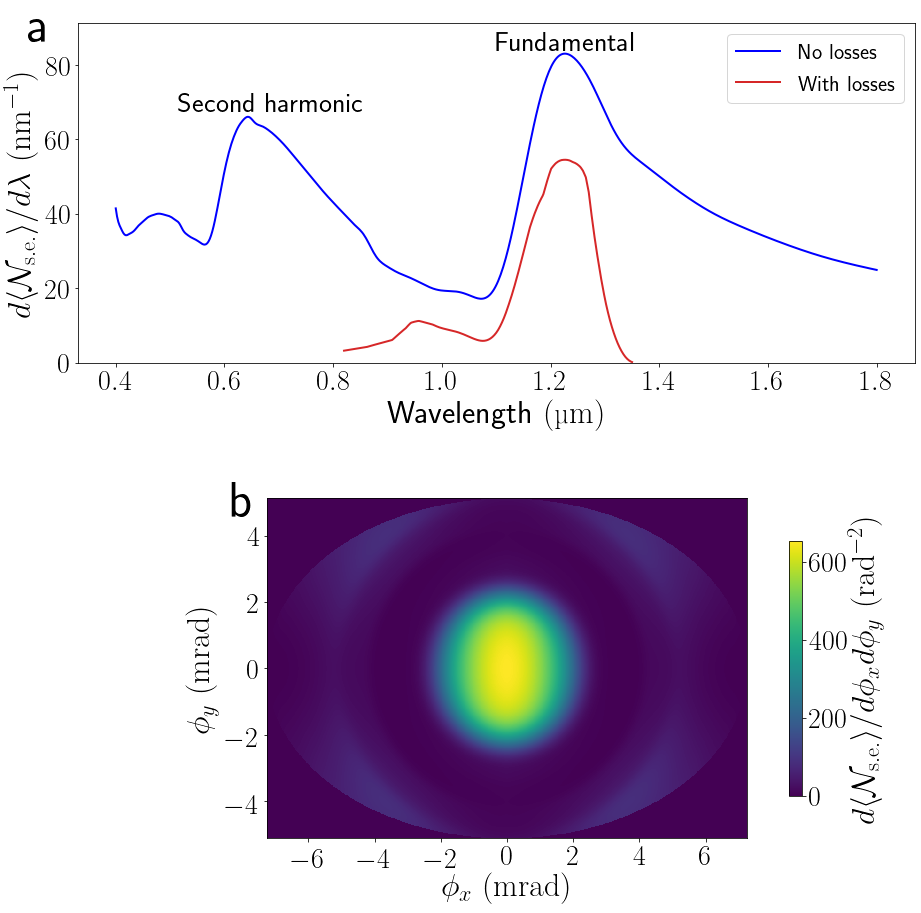

In [14]:
plt.rcParams["text.usetex"] =True
plt.rc('text.latex', preamble=
       r'\usepackage{siunitx}'
      +r'\newcommand{\None}{\langle\mathcal{N}_{\mathrm{s.e.}}\rangle}')
plt.rcParams.update({'font.size': 28,
                     'legend.fontsize':22,
                     'errorbar.capsize':3})
fig, axs = plt.subplots(2, figsize=(15, 15), gridspec_kw={'height_ratios': [1, 1]})
ax2, ax1 = axs[0], axs[1]
fs = 32

pcm = ax1.pcolormesh(1000*wr_sim.x_2D, 1000*wr_sim.y_2D, ang_dist)
asp = (ax1.get_ylim()[1]-ax1.get_ylim()[0])/(ax1.get_xlim()[1]-ax1.get_xlim()[0])
ax1.set_aspect(1/np.sqrt(2)*1/asp)
ax1.set_xlabel(r'$\phi_x$ $(\SI{}{mrad})$', fontsize=fs)
ax1.set_ylabel(r'$\phi_y$ $(\SI{}{mrad})$', fontsize=fs)
ax1.set_yticks(ticks=np.arange(-4,6,2))
ax1.set_xticks(ticks=np.arange(-6,8,2))

cb = fig.colorbar(pcm, ax=ax1, shrink=0.75,
                  #orientation='horizontal',
                  label=r"$d\None/d\phi_xd\phi_y$ $(\SI{}{rad^{-2}})$")
ax = cb.ax
text = ax.yaxis.label
font = matplotlib.font_manager.FontProperties(size=fs)
text.set_font_properties(font)

ax2.set_xlabel('Wavelength $(\SI{}{\micro m})$', fontsize=fs)
color = 'blue'
ax2.plot(
    l1d0,
    1000*spect_dist0,
    linewidth=2,color = color, label='No losses')
color = 'tab:red'
ax2.plot(
    wr_sim.lambda_range,
    1000*spect_dist,
    linewidth=2,color = color, label='With losses')
ax2.set_ylabel(
    r'$d\None/d\lambda$ $(\SI{}{nm^{-1}})$', fontsize=fs)
ax2.set_ylim(0,1.1*max(1000*spect_dist0))
ax2.legend()
#asp = (ax2.get_ylim()[1]-ax2.get_ylim()[0])/(ax2.get_xlim()[1]-ax2.get_xlim()[0])
#ax2.set_aspect(1/np.sqrt(2)*1/asp)
fs2 = 28
ax2.text(0.5,0.92,'Fundamental',fontsize=fs2,transform=ax2.transAxes)
ax2.text(0.12,0.74,'Second harmonic',fontsize=fs2,transform=ax2.transAxes)
ax2.set_yticks(ticks=np.arange(0,100,20))

for axx, label in zip((ax2, ax1),('a', 'b')):
    bbox = axx.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    width, height = bbox.width, bbox.height
    axx.text(-0.7/width, 1+0.25/height, label, transform=axx.transAxes,
      fontsize=50, fontweight='bold', va='top', ha='left')
plt.subplots_adjust(hspace=0.4)
plt.savefig(path_assistant.get_PRL_images_dir().fi("spectral_angular_distribution.png"),
            bbox_inches='tight',dpi=300)
plt.show()